# **DATA LOADING AND NORMALIZATION**

In [3]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score
from torchsummary import summary
import math

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224


def get_training_data(data_dir):
    data = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        #print(path)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                # Load and resize the image
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize the image
                
                # Add the image and label as a pair
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    
    # Convert the list to a NumPy array
    data = np.array(data, dtype=object)  # Use dtype=object to allow image-label pairing
    return data

# Load the data
train_data = get_training_data('../normData/train') 
test_data = get_training_data('../normData/test')
val_data = get_training_data( '../normData/val')

## **DATA Preparation**

Shape of train images: (7550, 224, 224)
Shape of validation images: (216, 224, 224)


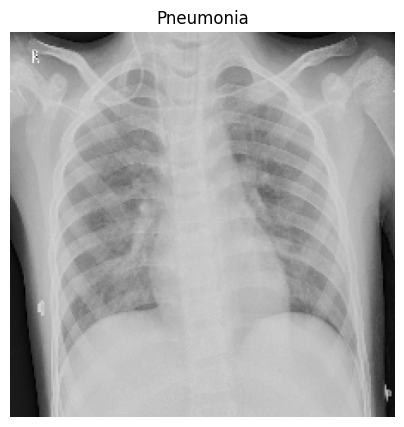

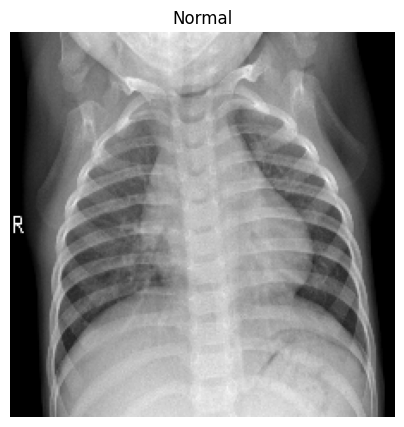

In [5]:
#Separate the images and the labels
train_images = np.array([x[0] for x in train_data])  # Extract only the images
train_labels = np.array([x[1] for x in train_data])  # Extract only the labels
    
val_images = np.array([x[0] for x in val_data])  # Extract only the images
val_labels = np.array([x[1] for x in val_data])  # Extract only the labels
    
test_images = np.array([x[0] for x in test_data])  # Extract only the images
test_labels = np.array([x[1] for x in test_data])  # Extract only the labels

# Check the shape and an example of the dataset
print(f"Shape of train images: {train_images.shape}")
print(f"Shape of validation images: {val_images.shape}")

# Display the first image from the training data
plt.figure(figsize=(5, 5))
plt.imshow(train_images[0], cmap='gray')
plt.title('Pneumonia' if train_labels[0] == 0 else 'Normal')
plt.axis('off')
plt.show()

# Display the last image from the validation data
plt.figure(figsize=(5, 5))
plt.imshow(val_images[-1], cmap='gray')
plt.title('Pneumonia' if val_labels[-1] == 0 else 'Normal')
plt.axis('off')
plt.show()

# **KAN REAL**

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset
import math
from typing import *

# Function to flatten images
def flatten_images(images):
    return torch.flatten(images, start_dim=1)


train_images_tensor = torch.tensor(train_images)
val_images_tensor = torch.tensor(val_images)
test_images_tensor = torch.tensor(test_images)

train_images_flat = flatten_images(train_images_tensor)
val_images_flat = flatten_images(val_images_tensor)
test_images_flat = flatten_images(test_images_tensor)

train_labels_tensors = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensors = torch.tensor(val_labels, dtype=torch.long)

train_dataset = TensorDataset(train_images_flat, train_labels_tensors)
val_dataset = TensorDataset(val_images_flat, val_labels_tensors)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class KAN_Net(nn.Module):
    def __init__(self, input_dim, hidden_dim=[128, 64], output_dim=2, polynomial_order=3, activation=nn.ReLU):
        super(KAN_Net, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.polynomial_order = polynomial_order
        self.activation = activation()

        poly_feature_size = (self.polynomial_order + 1) * self.input_dim

        self.base_layers = nn.ModuleList()
        in_dim = self.input_dim
        for dim in hidden_dim:
            self.base_layers.append(nn.Linear(in_dim, dim))
            in_dim = dim

        self.poly_weights = nn.ParameterList([
            nn.Parameter(torch.randn(dim, poly_feature_size)) for dim in hidden_dim
        ])

        self.output_layer = nn.Linear(in_dim, output_dim)

        for layer in self.base_layers:
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='linear')
        for weight in self.poly_weights:
            nn.init.kaiming_uniform_(weight, nonlinearity='linear')

    @staticmethod
    def compute_legendre_polynomials(x, order):
        P0 = torch.ones_like(x)
        P1 = x
        legendre_polys = [P0, P1]

        for n in range(1, order):
            Pn = ((2.0 * n + 1.0) * x * legendre_polys[-1] - n * legendre_polys[-2]) / (n + 1.0)
            legendre_polys.append(Pn)
        
        return torch.cat(legendre_polys, dim=-1)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        for layer, poly_weight in zip(self.base_layers, self.poly_weights):
            base_output = self.activation(layer(x))

            x_min = x.min(dim=1, keepdim=True)[0]
            x_max = x.max(dim=1, keepdim=True)[0]
            x_normalized = 2 * (x - x_min) / (x_max - x_min) - 1
            legendre_basis = self.compute_legendre_polynomials(x_normalized.unsqueeze(-1), self.polynomial_order)

            legendre_basis = legendre_basis.view(x.size(0), -1)  # Reshape to match poly_weight expectations

            # Adjust the dimension of the Legendre basis to match the poly_weight dimension
            if legendre_basis.shape[1] != poly_weight.shape[1]:
                legendre_basis = F.interpolate(legendre_basis.unsqueeze(1), size=(poly_weight.shape[1],), mode='linear', align_corners=False).squeeze(1)

            poly_output = torch.matmul(legendre_basis, poly_weight.T)
            x = self.activation(base_output + poly_output)

        x = self.output_layer(x)
        return x

# Setup and model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def initialize_kan_net(width, seed, device):
    torch.manual_seed(seed)
    input_dim = width[0]
    hidden_dim = width[1:]
    model = KAN_Net(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=2)
    model.to(device)
    return model

input_width = 224 * 224
model = initialize_kan_net(width=[input_width, 128, 64], seed=42, device=device)

# Removed torchsummary import and summary call

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

def calculate_precision_recall(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')

    return precision, recall

In [12]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score

# Assume train_images_flat, val_images_flat, and their corresponding label tensors are provided
# They were created using the flattening and tensor conversion logic



# Labels are already in tensor form from the previous code
train_labels_tensor = train_labels_tensors
val_labels_tensor = val_labels_tensors

# Create the dataset and DataLoader
train_dataset = TensorDataset(train_images_flat, train_labels_tensor)
val_dataset = TensorDataset(val_images_flat, val_labels_tensor)

# Define the batch size
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model and device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Correcting the input dimensions to match the flattened image dimensions
input_dim = train_images_tensor.shape[1]

# Define the loss function and optimizer 
criterion = nn.CrossEntropyLoss()  # For multi-class or binary classification
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # AdamW with L2 regularization 

# Now the data is ready for training and validation

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(torch.float32).to(device), labels.to(torch.long).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

        # Calculate average training loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_preds / total_preds
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(torch.float32).to(device), labels.to(torch.long).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct_preds += torch.sum(preds == labels).item()
                val_total_preds += labels.size(0)

        # Calculate validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct_preds / val_total_preds
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), "best_model_real.pth")
            print("Model saved!")
        else:
            epochs_without_improvement += 1
            print(f"Early Stopping Counter: {epochs_without_improvement}/{patience}")

        if epochs_without_improvement >= patience:
            print("Early stopping triggered. Stopping training.")
            break

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10)

Epoch 1/50
Train Loss: 0.2399, Train Accuracy: 0.9666
Validation Loss: 0.7452, Validation Accuracy: 0.9167
Model saved!
Epoch 2/50
Train Loss: 0.0893, Train Accuracy: 0.9816
Validation Loss: 0.4219, Validation Accuracy: 0.9120
Model saved!
Epoch 3/50
Train Loss: 0.0927, Train Accuracy: 0.9799
Validation Loss: 0.8743, Validation Accuracy: 0.8889
Early Stopping Counter: 1/10
Epoch 4/50
Train Loss: 0.0717, Train Accuracy: 0.9840
Validation Loss: 0.2818, Validation Accuracy: 0.9444
Model saved!


KeyboardInterrupt: 

In [10]:

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score

# Model and device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Correcting the input dimensions to match the flattened image dimensions
input_dim = train_images_flat.shape[1]  # Assuming train_images_flat was defined previously


input_width = 224 * 224
model = initialize_kan_net(width=[input_width, 128, 64], seed=42, device=device)
model = model.to(device)

# Load the saved model state
# Note: Be sure to use the appropriate path and file for your model
state_dict = torch.load("best_model_real.pth", weights_only=True)
model.load_state_dict(state_dict, strict=False)

def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            
            correct_preds += torch.sum(preds == target).item()
            total_preds += target.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    accuracy = correct_preds / total_preds

    return precision, recall, f1, accuracy

def validate_model(model, val_loader, device):
    precision, recall, f1, accuracy = calculate_metrics(model, val_loader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1-Score: {f1:.4f}")

# Validate the model on the validation dataset
validate_model(model, val_loader, device)

Validation Accuracy: 0.9583
Validation Precision: 0.9714
Validation Recall: 0.9444
Validation F1-Score: 0.9577


In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score

#Convert them to tensors if they aren't already
test_label_tensor = torch.tensor(test_labels, dtype=torch.long)
test_dataset = TensorDataset(test_images_flat, test_label_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)



def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            
            correct_preds += torch.sum(preds == target).item()
            total_preds += target.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    accuracy = correct_preds / total_preds

    return precision, recall, f1, accuracy

def test_model(model, test_loader, device):
    precision, recall, f1, accuracy = calculate_metrics(model, test_loader, device)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")


input_width = 224 * 224
model = initialize_kan_net(width=[input_width, 128, 64], seed=42, device=device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the saved model state
#model.load_state_dict(torch.load("best_model_v4.pth"))
#model.eval()

# Load the saved state_dict
state_dict = torch.load("best_model_real.pth", weights_only=True)

model.load_state_dict(state_dict, strict=False)
model.load_state_dict(state_dict)


# Print the state_dict keys of your current model
current_state_dict = model.state_dict()
#print("Current Model State Dict Keys:", list(current_state_dict.keys()))

test_model(model, test_loader, device)

Test Accuracy: 0.7452
Test Precision: 0.9412
Test Recall: 0.3419
Test F1-Score: 0.5016
